# 数据清洗与可视化

## 引入部分包

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns
from plotnine import *
import chardet
import jieba
from PIL import Image
import os
from os import path
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from matplotlib.pyplot import figure, show, rc
from matplotlib import cm,colors
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.sans-serif"] = ["SimHei"] #解决中文字符乱码的问题

## 读取数据

In [2]:
df =  pd.read_csv('..\数据\movie_data.csv')
df.describe()  # 数值类型数据描述:没有显著异常的取值 
df.info()     # 数据信息，有大量缺失值
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                5043 non-null   object 
 1   language                   5031 non-null   object 
 2   country                    5038 non-null   object 
 3   content_rating             4740 non-null   object 
 4   title_year                 4935 non-null   object 
 5   color                      5024 non-null   object 
 6   duration                   5028 non-null   float64
 7   genres                     5043 non-null   object 
 8   plot_keywords              4890 non-null   object 
 9   budget                     4551 non-null   float64
 10  gross                      4159 non-null   float64
 11  aspect_ratio               4714 non-null   float64
 12  facenumber_in_poster       5043 non-null   int64  
 13  director_name              4939 non-null   objec

,movie_title,language,country,content_rating,title_year,color,duration,genres,plot_keywords,budget,...,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,num_voted_users,num_user_for_reviews,num_critic_for_reviews,movie_facebook_likes,cast_total_facebook_likes,movie_imdb_link,imdb_score
0,Avatar,English,USA,PG-13,2009-02,Color,178.0,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,237000000.0,...,936.0,Wes Studi,855.0,886204,3054.0,723.0,33000,4834,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,7.9
1,Pirates of the Caribbean: At World's End,English,USA,PG-13,2007-09,Color,169.0,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,300000000.0,...,5000.0,Jack Davenport,1000.0,471220,1238.0,302.0,0,48350,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,7.1


## 数据清洗

In [3]:
# 语言为空但是国家非空的，全是USA，所以将对应的语言设为English
index_language = df[(df['language'].isnull()) & (df['country'].notnull())].index  
df['language'][index_language] = 'English'

In [4]:
df['color'].fillna('Color',inplace=True)             #默认缺失值均为彩色
df['content_rating'].fillna('G',inplace=True)        #默认影片分级为G级
df['director_name'].fillna('unknown',inplace=True)   #默认导演名、演员名缺失为unknown
df['director_facebook_likes'].fillna(0,inplace=True) #默认导演FB粉丝数、演员FB粉丝数缺失为0
df['actor_1_name'].fillna('unknown',inplace=True)
df['actor_1_facebook_likes'].fillna(0,inplace=True)
df['actor_2_name'].fillna('unknown',inplace=True)
df['actor_2_facebook_likes'].fillna(0,inplace=True)
df['actor_3_name'].fillna('unknown',inplace=True)
df['actor_3_facebook_likes'].fillna(0,inplace=True)
df['num_user_for_reviews'].fillna(0,inplace=True)
df['num_critic_for_reviews'].fillna(0,inplace=True)
df = df.dropna(how='any') #丢弃空值

In [5]:
df = df[-df.language.isin(['None'])] #df[df['language']=='None'].index，删除语言为None
df = df[-df.content_rating.isin(['Approved','M','Not Rated','Passed','Unrated','X'])] #删除电影等级不在考虑范围内的
df.iloc[2999,3] = 'PG'      #df[df['content_rating']== 'GP'].index，修改GP为PG
df.reset_index(drop=True, inplace=True)  #重新设置索引标签
df.to_csv("../数据/cleared_data.csv")

In [6]:
# data数据集用作探索性可视化分析
data = df.copy()
data['year'] = data['title_year'].apply(lambda x: x[:4]).astype('int')  #添加年列和月列
data['month'] = data['title_year'].apply(lambda x: x[5:]).astype('int')
data['time_class'] = pd.cut(x=data['duration'], bins=[0,90,100,110,120,130,1000], labels=list('ABCDEF'))
data['gross_yi'] = round(data['gross']/100000000,2)
data.head(2)

,movie_title,language,country,content_rating,title_year,color,duration,genres,plot_keywords,budget,...,num_user_for_reviews,num_critic_for_reviews,movie_facebook_likes,cast_total_facebook_likes,movie_imdb_link,imdb_score,year,month,time_class,gross_yi
0,Avatar,English,USA,PG-13,2009-02,Color,178.0,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,237000000.0,...,3054.0,723.0,33000,4834,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,7.9,2009,2,F,7.61
1,Pirates of the Caribbean: At World's End,English,USA,PG-13,2007-09,Color,169.0,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,300000000.0,...,1238.0,302.0,0,48350,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,7.1,2007,9,F,3.09


## 探索性数据分析

### 电影分类情况

In [7]:
# 电影按语言分类情况
data["language"].value_counts()

English       3554
French          32
Spanish         23
Mandarin        14
German          11
Japanese        10
Cantonese        8
Hindi            7
Korean           5
Portuguese       4
Italian          4
Dutch            3
Thai             3
Norwegian        3
Dari             2
Persian          2
Danish           2
Aboriginal       2
Dzongkha         1
Russian          1
Arabic           1
Hebrew           1
Vietnamese       1
Indonesian       1
Zulu             1
Bosnian          1
Czech            1
Icelandic        1
Hungarian        1
Mongolian        1
Aramaic          1
Telugu           1
Kazakh           1
Maya             1
Filipino         1
Swedish          1
Name: language, dtype: int64

In [8]:
# 电影按国家分类情况
data["country"].value_counts()

USA               2955
UK                 309
France              97
Germany             81
Canada              58
Australia           39
Spain               20
Japan               15
China               15
Hong Kong           13
New Zealand         11
India               10
South Korea          8
Ireland              7
Italy                7
Mexico               6
Denmark              6
Brazil               4
Thailand             4
South Africa         3
Argentina            3
Czech Republic       3
Iran                 3
Netherlands          3
Norway               3
Russia               3
Iceland              2
Hungary              2
Colombia             1
Poland               1
Indonesia            1
Afghanistan          1
Israel               1
Chile                1
Georgia              1
West Germany         1
Official site        1
Taiwan               1
Greece               1
Belgium              1
Romania              1
Aruba                1
Peru                 1
New Line   

In [9]:
# 电影按观看人群分类情况
data["content_rating"].value_counts() 

R        1702
PG-13    1313
PG        569
G         117
NC-17       6
Name: content_rating, dtype: int64

In [10]:
# 电影按色彩分类情况
data['color'].value_counts()

Color               3594
 Black and White     113
Name: color, dtype: int64

### 部分字段最值信息

In [11]:
# 票房最高的电影
data.sort_values(by='gross',ascending=False).iloc[0]

movie_title                                                            Avatar 
language                                                               English
country                                                                    USA
content_rating                                                           PG-13
title_year                                                             2009-02
color                                                                    Color
duration                                                                 178.0
genres                                         Action|Adventure|Fantasy|Sci-Fi
plot_keywords                           avatar|future|marine|native|paraplegic
budget                                                             237000000.0
gross                                                              760505847.0
aspect_ratio                                                              1.78
facenumber_in_poster                                

In [12]:
# 评分最高的电影
data.sort_values(by='imdb_score',ascending=False).iloc[0]

movie_title                                          The Shawshank Redemption 
language                                                               English
country                                                                    USA
content_rating                                                               R
title_year                                                             1994-02
color                                                                    Color
duration                                                                 142.0
genres                                                             Crime|Drama
plot_keywords                escape from prison|first person narration|pris...
budget                                                              25000000.0
gross                                                               28341469.0
aspect_ratio                                                              1.85
facenumber_in_poster                                

In [13]:
# 参与评分人数最多的电影
data.sort_values(by='num_voted_users',ascending=False).iloc[0]

movie_title                                          The Shawshank Redemption 
language                                                               English
country                                                                    USA
content_rating                                                               R
title_year                                                             1994-02
color                                                                    Color
duration                                                                 142.0
genres                                                             Crime|Drama
plot_keywords                escape from prison|first person narration|pris...
budget                                                              25000000.0
gross                                                               28341469.0
aspect_ratio                                                              1.85
facenumber_in_poster                                

In [14]:
# 评论最多的电影
data.sort_values(by='num_user_for_reviews',ascending=False).iloc[0]

movie_title                  The Lord of the Rings: The Fellowship of the R...
language                                                               English
country                                                            New Zealand
content_rating                                                           PG-13
title_year                                                             2001-11
color                                                                    Color
duration                                                                 171.0
genres                                          Action|Adventure|Drama|Fantasy
plot_keywords                               elf|hobbit|middle earth|quest|ring
budget                                                              93000000.0
gross                                                              313837577.0
aspect_ratio                                                              2.35
facenumber_in_poster                                

In [15]:
# FaceBook点赞数最高的影片
data.sort_values(by='movie_facebook_likes',ascending=False).iloc[0]

movie_title                                                      Interstellar 
language                                                               English
country                                                                    USA
content_rating                                                           PG-13
title_year                                                             2014-12
color                                                                    Color
duration                                                                 169.0
genres                                                  Adventure|Drama|Sci-Fi
plot_keywords                black hole|father daughter relationship|saving...
budget                                                             165000000.0
gross                                                              187991439.0
aspect_ratio                                                              2.35
facenumber_in_poster                                

In [16]:
# 最受欢迎的导演
data.sort_values(by='director_facebook_likes',ascending=False).iloc[0]

movie_title                                                           Don Jon 
language                                                               English
country                                                                    USA
content_rating                                                               R
title_year                                                             2013-03
color                                                                    Color
duration                                                                  90.0
genres                                                    Comedy|Drama|Romance
plot_keywords                camera focus on female butt|cunnilingus|new je...
budget                                                               3000000.0
gross                                                               24475193.0
aspect_ratio                                                              2.35
facenumber_in_poster                                

### 部分可视化

In [17]:
cmap=cm.get_cmap('Blues_r',6)
color=[colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)] 

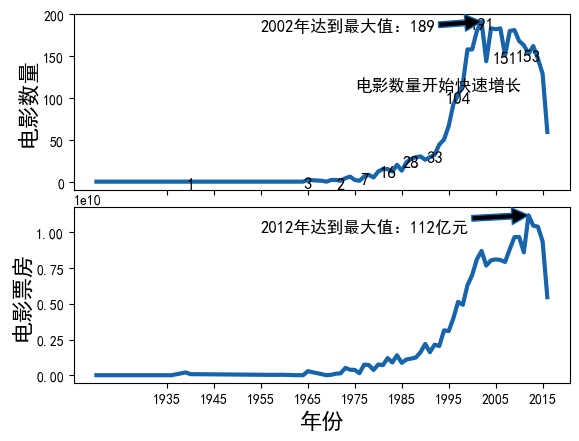

In [18]:
# 每年电影数量和电影总票房分布
movie_count_year = data["year"].value_counts()
movie_count_year = movie_count_year.sort_index()
x = movie_count_year.index
y1 = movie_count_year.values

movie_total_gross_year = data['gross'].groupby(data['year']).sum()
x = movie_total_gross_year.index
y2 = movie_total_gross_year.values

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)

axs[0].plot(x,y1,color =color[1],linewidth=3)
axs[0].set_ylabel("电影数量",fontsize = 16)
axs[0].set_xticks(np.arange(1935, 2016, step=10))

for (a,b) in zip(x[3::5],y1[3::5]): # 每隔5年进行数量标记，防止过于密集
    axs[0].text(a,b+5,b,ha = "center", va = "top", fontsize = 12)

# 带有文本信息的箭头
axs[0].annotate("2002年达到最大值：189", xy = (2002,movie_count_year[2002]), xytext = (1955,180), 
             arrowprops = dict(facecolor = "black",edgecolor = color[1]), fontsize=12)

# 纯文本注释内容，注释增长最快的地方
axs[0].text(1975,110,"电影数量开始快速增长",fontsize=12)


axs[1].plot(x,y2,color =color[1],linewidth=3)
axs[1].set_ylabel("电影票房",fontsize = 16)
axs[1].set_xlabel("年份",fontsize = 16)
axs[1].set_xticks(np.arange(1935, 2016, step=10))

# 带有文本信息的箭头
axs[1].annotate("2012年达到最大值：112亿元", xy = (2012,movie_total_gross_year[2012]), xytext = (1955,10000000000), 
             arrowprops = dict(facecolor = "black",edgecolor = color[1]), fontsize=12)

plt.show()

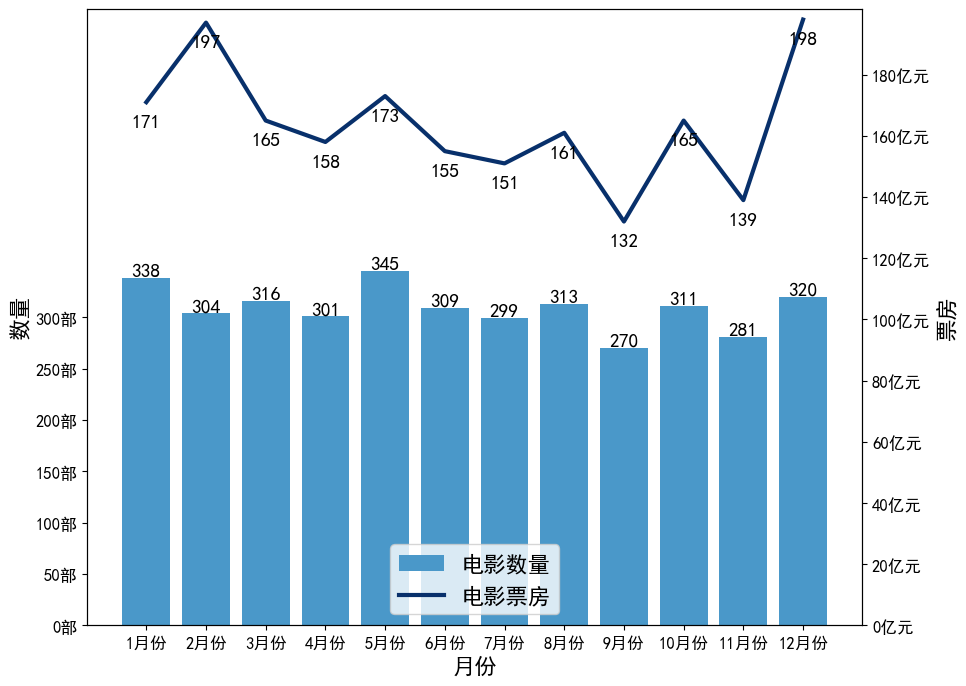

In [19]:
# 每月电影数量以及电影总票房
fig , ax1 = plt.subplots(figsize=(10,8))  
movie_count_month = data.groupby('month')['movie_title'].count() 

x = movie_count_month.index.astype('int')  
y1 = movie_count_month.values.astype('int')

x_ticks_label =  ['{}月份'.format(i) for i in x]  
ax1.set_xticks(x) 
ax1.set_xticklabels(x_ticks_label, fontsize = 12) 

y1_ticks= np.arange(0,max(y1),50) 
y1_ticks_label =  ['{}部'.format(i) for i in y1_ticks] 
ax1.set_yticks(y1_ticks) 
ax1.set_yticklabels(y1_ticks_label, fontsize = 12)
ax1.set_ylim(0, 600) 

ax1.bar(x,y1,label='电影数量',color=color[2])
ax1.set_xlabel('月份',fontsize = 16) 
ax1.set_ylabel('数量',fontsize = 16)

for a,b in zip(x,y1):
    ax1.text(a,b,b,ha = "center",va = "bottom",fontsize = 14) 


    
movie_total_gross_month = data.groupby('month')['gross'].sum()/100000000 

ax2 = ax1.twinx() 
y2 = movie_total_gross_month.values.astype('int')
ax2.plot(x,y2,'-',label='电影票房', color=color[0],linewidth=3)

y2_ticks = np.arange(0,max(y2),20)  
y2_ticks_label =  ['{}亿元'.format(i) for i in y2_ticks]  
ax2.set_yticks(y2_ticks) 
ax2.set_yticklabels(y2_ticks_label,fontsize = 12)  
ax2.set_ylabel('票房',fontsize = 16)

for a,b in zip(x,y2): 
    plt.text(a,b-4,round(b,0),ha = "center",va = "top",fontsize = 14) 

# 设置图例
handles1, labels1 = ax1.get_legend_handles_labels() 
handles2, labels2 = ax2.get_legend_handles_labels() 
plt.legend(handles1+handles2, labels1+labels2, loc='lower center', fontsize=16) 
plt.show()

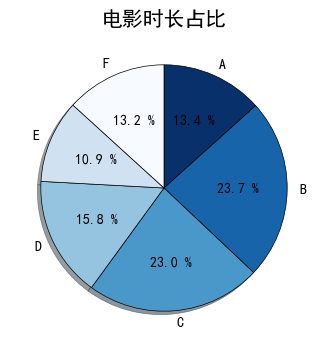

In [20]:
# 电影时长占比饼图
duration_cut = data['time_class'].value_counts().sort_index() 
plt.figure(figsize = (5,4))
plt.title("电影时长占比",fontsize = 15)
patches,l_text,p_text = plt.pie(duration_cut.values, labels = duration_cut.index, autopct = "%.1f %%", startangle = 90,
                                shadow=True, counterclock=False,colors=color, wedgeprops =dict(linewidth=0.5, edgecolor='k'))
plt.show()

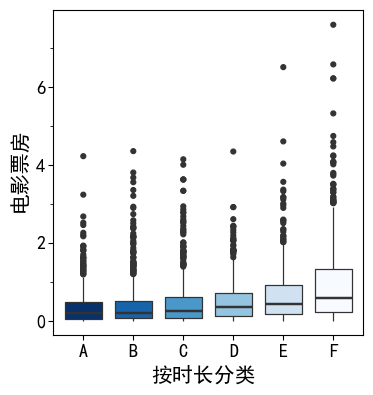

<ggplot: (-9223371951515245796)>

In [21]:
# 各时长电影票房分布箱线图
(
    ggplot(data,aes(x='time_class',y="gross_yi",fill="time_class"))
    + geom_boxplot(show_legend=False)
    + scale_fill_manual(values=color)
    + theme_matplotlib()
    + labs(x='按时长分类',y='电影票房')
    + theme(aspect_ratio =1.05,dpi=100,figure_size=(4,4),
            axis_title=element_text(size=15,face="plain",color="black"),
            axis_text = element_text(size=13,face="plain",color="black"),
            legend_text = element_text(size=11,face="plain",color="black"),
            legend_title = element_text(size=13,face="plain",color="black"),
            legend_background=element_blank(),
            legend_position=(0,0))
)

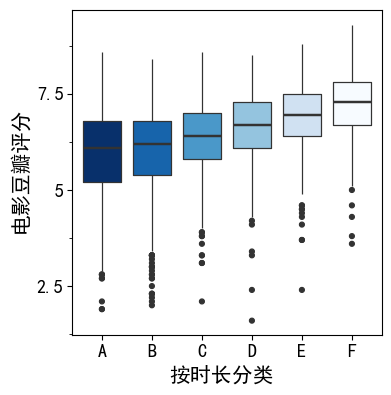

<ggplot: (-9223371951515278288)>

In [22]:
#各时长电影票房分布箱线图
(
    ggplot(data,aes(x='time_class',y="imdb_score",fill="time_class"))
    + geom_boxplot(show_legend=False)
    + scale_fill_manual(values=color)
    + theme_matplotlib()
    + labs(x='按时长分类',y='电影豆瓣评分')
    + theme(aspect_ratio =1.05,dpi=100,figure_size=(4,4),
            axis_title=element_text(size=15,face="plain",color="black"),
            axis_text = element_text(size=13,face="plain",color="black"),
            legend_text = element_text(size=11,face="plain",color="black"),
            legend_title = element_text(size=13,face="plain",color="black"),
            legend_background=element_blank(),
            legend_position=(0,0))
)

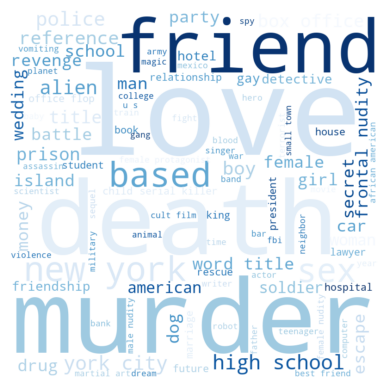

In [23]:
# 电影关键词词云图
# 获取当前文件路径
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
# 获取文本text
text = open(path.join(d,'../数据/keywords.txt')).read()
# 生成词云

#wc是一个类
wc=WordCloud(font_path=None,  # 字体路径，英文不用设置路径，中文需要，否则无法正确显示图形
    width=400, # 默认宽度
    height=400, # 默认高度
    margin=2, # 边缘
    ranks_only=None, 
    prefer_horizontal=0.9, 
    mask=None, # 背景图形，如果想根据图片绘制，则需要设置
    scale=2, 
    color_func=None, 
    max_words=100, # 最多显示的词汇量
    min_font_size=4, # 最小字号
    stopwords=None, # 停止词设置，修正词云图时需要设置
    random_state=None, 
    background_color='white', # 背景颜色设置，可以为具体颜色,比如white或者16进制数值
    max_font_size=None, # 最大字号
    font_step=1, 
    mode='RGB', 
    relative_scaling='auto', 
    regexp=None, 
    collocations=True, 
    colormap='Blues_r', # matplotlib 色图，可更改名称进而更改整体风格
    normalize_plurals=True, 
    contour_width=0, 
    contour_color='black', 
    repeat=False)

wc.generate_from_text(text)
# 显示图像

fig = figure(figsize=(4,4),dpi =100)  
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

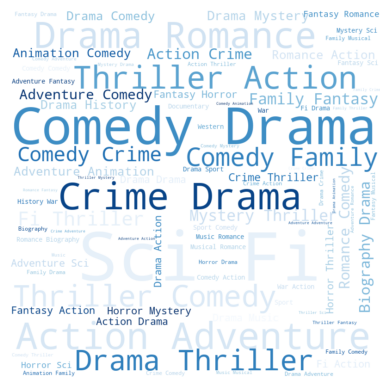

In [24]:
# 电影题材词云图
# 获取当前文件路径
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
# 获取文本text
text = open(path.join(d,'../数据/genre.txt')).read()
# 生成词云

# wc是一个类
wc=WordCloud(font_path=None,  # 字体路径，英文不用设置路径，中文需要，否则无法正确显示图形
    width=400, # 默认宽度
    height=400, # 默认高度
    margin=2, # 边缘
    ranks_only=None, 
    prefer_horizontal=0.9, 
    mask=None, # 背景图形，如果想根据图片绘制，则需要设置
    scale=2, 
    color_func=None, 
    max_words=100, # 最多显示的词汇量
    min_font_size=4, # 最小字号
    stopwords=None, # 停止词设置，修正词云图时需要设置
    random_state=None, 
    background_color='white', # 背景颜色设置，可以为具体颜色,比如white或者16进制数值
    max_font_size=None, # 最大字号
    font_step=1, 
    mode='RGB', 
    relative_scaling='auto', 
    regexp=None, 
    collocations=True, 
    colormap='Blues_r', # matplotlib 色图，可更改名称进而更改整体风格
    normalize_plurals=True, 
    contour_width=0, 
    contour_color='black', 
    repeat=False)

wc.generate_from_text(text)
# 显示图像

fig = figure(figsize=(4,4),dpi =100)  
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [25]:
# 将电影按类型进行拆分
genre_data = pd.DataFrame(columns=['genre','gross','imdb_score']) 
for i,row_data  in data.iterrows(): 
    # 分割体裁类型 
    genres = row_data['genres'].split("|") 
    # 每一部电影体裁个数 
    n_genres = len(genres)    
    dict_obj = {} 
    dict_obj['gross'] = [row_data['gross_yi']] * n_genres 
    dict_obj['imdb_score'] = [row_data['imdb_score']] * n_genres 
    dict_obj['genre'] = genres   
    # 每一部电影的数据字典类型转化成DataFrame形式 
    genre_df = pd.DataFrame(dict_obj)  
    # 存储所有的电影电影类型及票房
    genre_data = genre_data.append(genre_df) 
genre_data.to_csv("../数据/genre_data.csv")

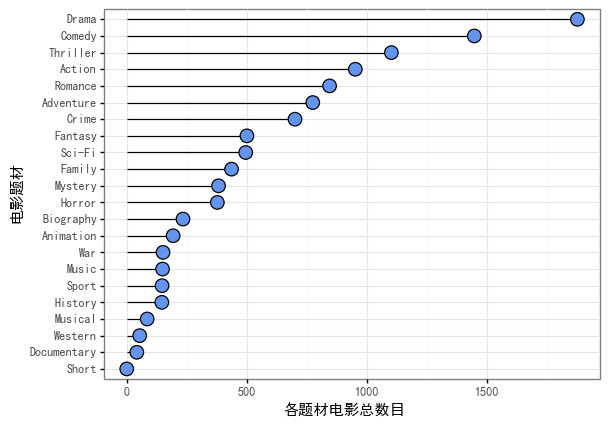

<ggplot: (-9223371951513646076)>

In [26]:
# 各题材电影数目的克利夫兰点图
movie_count_genre = genre_data.groupby('genre').size().sort_values()
movie_count_genre = pd.DataFrame(movie_count_genre, columns=['count'])
movie_count_genre.reset_index(inplace=True)
movie_count_genre['genre'] = pd.Categorical(movie_count_genre['genre'], categories=movie_count_genre['genre'], ordered=True) 
(
    ggplot(movie_count_genre, aes('count','genre'))
    + geom_segment(aes(x=0, xend='count', y='genre', yend='genre'))
    + geom_point(shape='o', size=5, color='k', fill='#6495ED')
    + theme_bw()
    + labs(x='各题材电影总数目', y='电影题材')
    + theme(text=element_text(family="SimHei"))
)

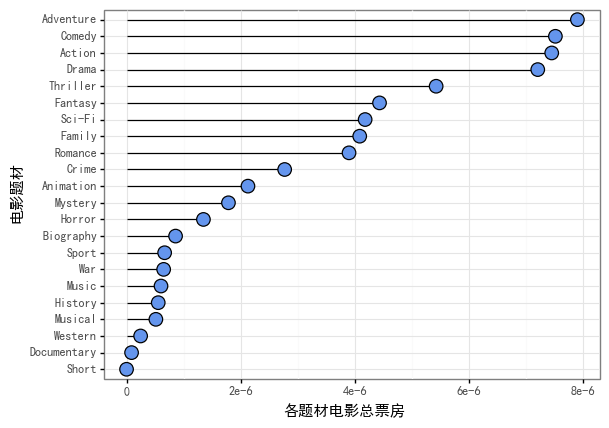

<ggplot: (-9223371951513183572)>

In [27]:
# 各题材电影总票房的克利夫兰点图
movie_total_gross_genre = genre_data.groupby('genre')['gross'].sum()/100000000
movie_total_gross_genre = pd.DataFrame(movie_total_gross_genre)
movie_total_gross_genre.reset_index(inplace=True)
movie_total_gross_genre.sort_values(by='gross',inplace=True)
movie_total_gross_genre.reset_index(drop=True,inplace=True)
movie_total_gross_genre['genre'] = pd.Categorical(movie_total_gross_genre['genre'], categories=movie_total_gross_genre['genre'], ordered=True) 
(
    ggplot(movie_total_gross_genre, aes('gross','genre'))
    + geom_segment(aes(x=0, xend='gross', y='genre', yend='genre'))
    + geom_point(shape='o', size=5, color='k', fill='#6495ED')
    + theme_bw()
    + labs(x='各题材电影总票房', y='电影题材')
    + theme(text=element_text(family="SimHei"))
)

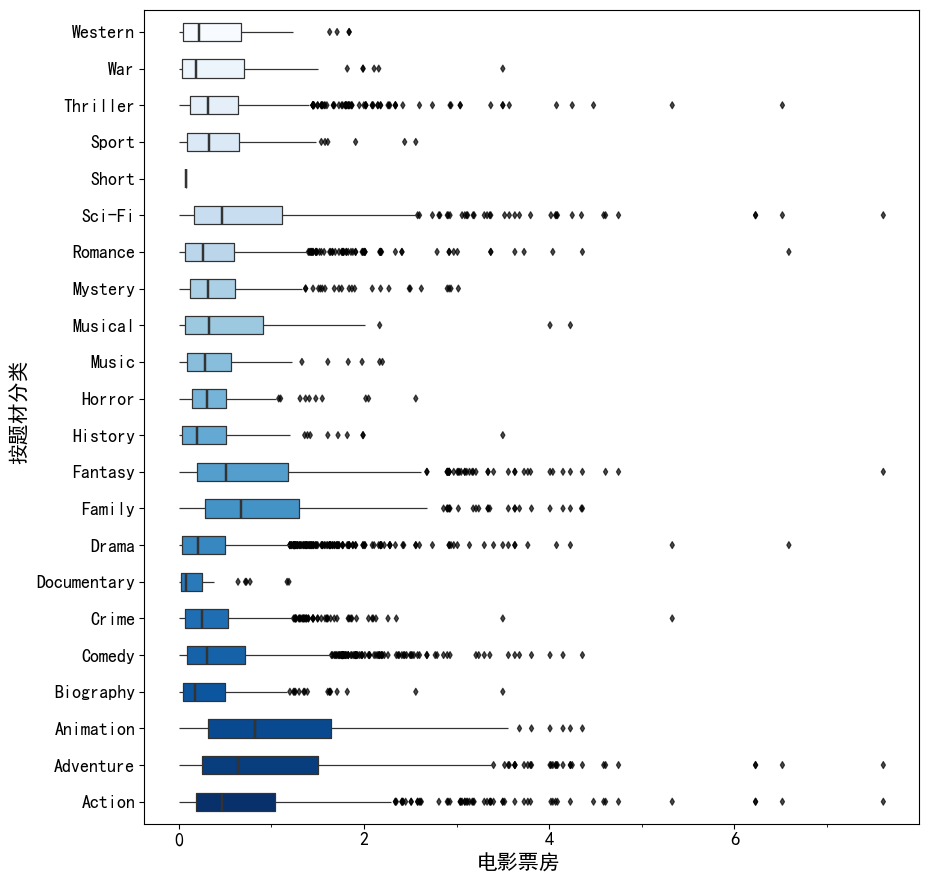

<ggplot: (-9223371951513829996)>

In [28]:
#各类型电影票房分布箱线图
cmap=cm.get_cmap('Blues_r',22)
color=[colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)] 
(
    ggplot(genre_data,aes(x='genre',y="gross",fill="genre"))
    + geom_boxplot(show_legend=False,outlier_color='black',outlier_shape='d',outlier_alpha=0.7,width=0.5)
    + scale_fill_manual(values=color)
    + coord_flip()
    + theme_matplotlib()
    + labs(x='按题材分类',y='电影票房')
    + theme(aspect_ratio =1.05,dpi=100,figure_size=(10,20),
            axis_title=element_text(size=15,face="plain",color="black"),
            axis_text = element_text(size=13,face="plain",color="black"),
            legend_text = element_text(size=11,face="plain",color="black"),
            legend_title = element_text(size=13,face="plain",color="black"),
            legend_background=element_blank(),
            legend_position=(0,0))
)

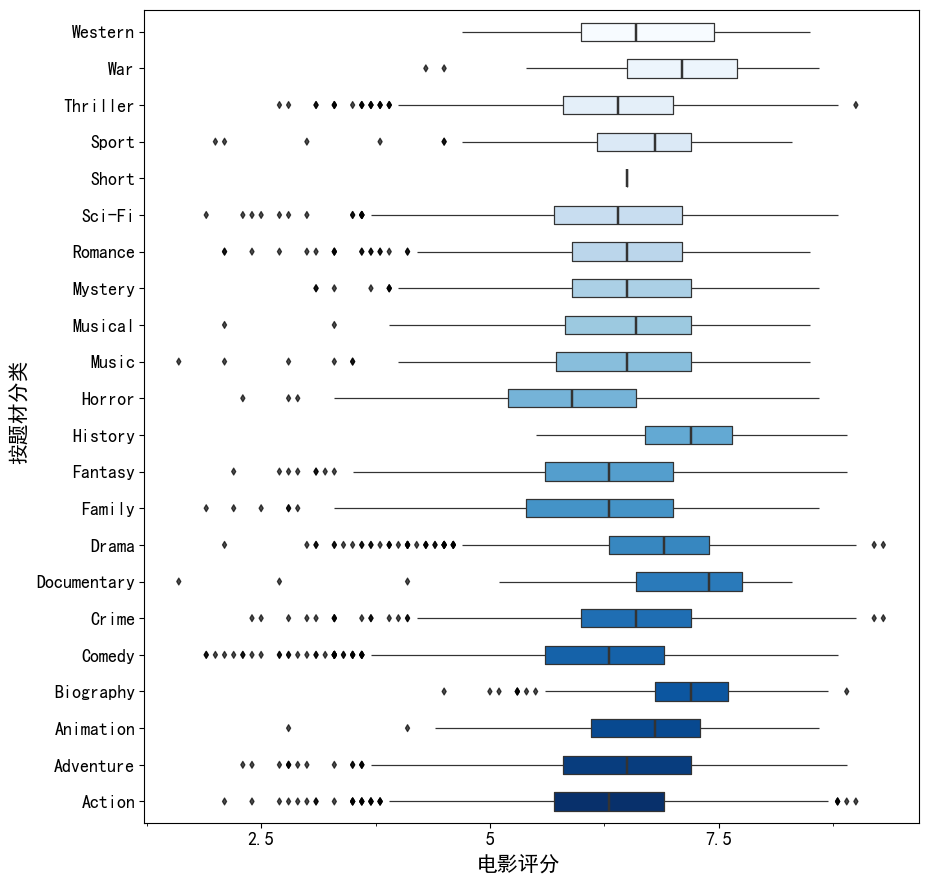

<ggplot: (-9223371951513834988)>

In [29]:
#各类型电影评分分布箱线图
(
    ggplot(genre_data,aes(x='genre',y="imdb_score",fill="genre"))
    + geom_boxplot(show_legend=False,outlier_color='black',outlier_shape='d',outlier_alpha=0.7,width=0.5)
    + scale_fill_manual(values=color)
    + coord_flip()
    + theme_matplotlib()
    + labs(x='按题材分类',y='电影评分')
    + theme(aspect_ratio =1.05,dpi=100,figure_size=(10,20),
            axis_title=element_text(size=15,face="plain",color="black"),
            axis_text = element_text(size=13,face="plain",color="black"),
            legend_text = element_text(size=11,face="plain",color="black"),
            legend_title = element_text(size=13,face="plain",color="black"),
            legend_background=element_blank(),
            legend_position=(0,0))
)

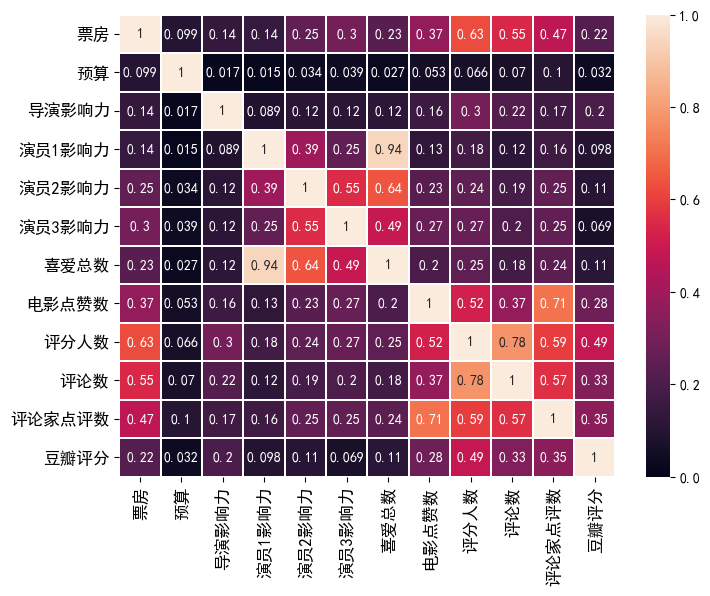

In [30]:
corr_data = data[['gross','budget','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
              'cast_total_facebook_likes','movie_facebook_likes','num_voted_users','num_user_for_reviews',
              'num_critic_for_reviews','imdb_score']]
corr_data.columns=['票房','预算','导演影响力','演员1影响力','演员2影响力','演员3影响力','喜爱总数','电影点赞数','评分人数','评论数',
               '评论家点评数','豆瓣评分']
corr = corr_data.corr() #获取相关系数
corr = abs(corr) #取绝对值

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

ax = sns.heatmap(corr,vmax = 1,vmin = 0,annot = True,annot_kws = {"size":10,"weight":"bold"},linewidths = 0.05)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()